## 멀티 모달 RAG



## Packages

아래 pip 패키지들 외에도, 시스템에 `poppler` ([설치 안내](https://pdf2image.readthedocs.io/en/latest/installation.html)) 및 `tesseract` ([설치 안내](https://tesseract-ocr.github.io/tessdoc/Installation.html))가 필요합니다.

In [6]:
! pip install -U langchain openai langchain-chroma langchain-experimental

In [7]:
! pip install pillow pydantic lxml pillow matplotlib chromadb tiktoken "unstructured[all-docs]"

## 데이터 로딩
### PDF의 표, 텍스트, 이미지 분할


In [8]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# PDF에서 요소 추출
def extract_pdf_elements(path, fname):
    """
    PDF 파일에서 이미지, 테이블, 텍스트 블록을 추출합니다.
    path: 파일 경로 (이미지 파일이 저장될 위치)
    fname: 파일 이름
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,  # PDF에서 이미지를 추출
        infer_table_structure=True,  # 테이블 구조를 추론
        chunking_strategy="by_title",  # 타이틀을 기준으로 텍스트를 블록으로 분할
        max_characters=4000,  # 최대 4000자로 텍스트 블록을 제한
        new_after_n_chars=3800,  # 3800자 이후에 새로운 블록 생성
        combine_text_under_n_chars=2000,  # 2000자 이하의 텍스트는 결합
        image_output_dir_path=path,  # 이미지가 저장될 경로 설정
        # image_output_dir_path=os.path.join(os.getcwd(),"figures"),
    )


# 추출한 요소를 유형별로 분류
def categorize_elements(raw_pdf_elements):
    """
    PDF에서 추출한 요소들을 테이블과 텍스트로 분류합니다.
    raw_pdf_elements: unstructured.documents.elements 리스트
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))  # 테이블 요소를 저장
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))  # 텍스트 요소를 저장
    return texts, tables

/Users/usermackbookpro/miniconda3/envs/hanbit-langchain/lib/python3.12/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4
/Users/usermackbookpro/miniconda3/envs/hanbit-langchain/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import os

current_directory = os.getcwd()
fname = "invest.pdf"
fpath = os.path.join(os.path.dirname(current_directory), "invest/")

print("현재 스크립트의 위치:", current_directory)
print("pdf 위치:",fpath)

현재 스크립트의 위치: /Users/usermackbookpro/hanbit-langchain/chapter 14/langchain-pdf-multimodal-openSource
pdf 위치: /Users/usermackbookpro/hanbit-langchain/chapter 14/invest/


### 요소 추출

`extract_pdf_elements(fpath, fname)`: PDF 파일의 경로와 이름을 받아서 PDF 요소를 추출합니다.

### 텍스트와 표 요소 분류

`categorize_elements(raw_pdf_elements)`: 추출된 요소를 텍스트와 표로 분류합니다.

### 선택사항: 텍스트의 특정 토큰 크기 강제 적용

`CharacterTextSplitter.from_tiktoken_encoder(...)`: 텍스트를 특정 크기로 분할하기 위해 텍스트 분할기를 초기화합니다.
- `chunk_size=2000`: 각 텍스트 청크의 최대 크기를 2000자로 설정합니다.
- `chunk_overlap=200`: 청크 간의 겹침을 200자로 설정합니다.
- `joined_texts = " ".join(texts)`: 모든 텍스트를 하나의 문자열로 결합합니다.
- `texts_2k_token = text_splitter.split_text(joined_texts)`: 결합된 텍스트를 설정한 크기와 겹침으로 분할합니다.

In [10]:
# PDF에서 요소 추출
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# 텍스트와 테이블 추출
texts, tables = categorize_elements(raw_pdf_elements)

# 선택 사항: 텍스트에 대해 특정 토큰 크기 적용
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=200
)
joined_texts = " ".join(texts)

# 2k 토큰 크기로 텍스트 분할
texts_2k_token = text_splitter.split_text(joined_texts)

In [11]:
# text 분할 개수 확인 
print(len(texts_2k_token))
print(len(texts))

3
2


In [12]:
#0번쨰 texts[0]번 데이터 데이터 타입 확인
print(texts[0])
print(type(texts))

<< () warsrts2

시황 코멘트

금리 멈춰야 주가 멈춘다

2024년 8월 5일

주식시황

“3 s LLL LL

FLISILLLLI LLL LL LLL LLL LLL LLL LLL LLL LLL LLL LL

Market Analyst 김수연 sooyeon.k@hanwha.com 3772-7628

ISM 46.8에 경기침체 오지 않습니다

2일 KOSPI가 101p빠져 2,676.2p까지 내렸다. 전일 7월 미 ISM제조업지수가 예상치를 밑돌며 경기에 대한 우려가 생겼 고 금리와 주가가 함께 하락한 영향이다. 이번주 발표된 빅테크와 반도체 기업들의 2분기 실적과 3분기 가이던스도 컨센 서스를 하회하는 케이스들이 많았다.

이날 국내 금리도 영향을 받으면서 10년 국고금리가 3%를 하회했고 주식시장은 그간 주도주 역할을 했던 반도체, 전력 기기를 중심으로 하락폭이 확대됐다. 삼성전자 -4%, SK하이닉스 -10%, HD현대일렉트릭 -13% 등이다.

7월 미 ISM제조업지수는 46.8p로 4개월 연속 하락했다. 예상치는 48.8p, 전월치는 48.5p였다. 수요가 전반적으로 둔화 되면서 신규 주문, 신규 수출주문, 수주잔고, 재고가 모두 낮은 수준에 머물렀다. 전저점인 2023년 6월 46.4p에 거의 근 접했다.

금리가 주가를 함께 끌어내리고 있어서 결국 금리 하락이 멈춰야 주가도 바닥을 잡을 수 있다. 당사 투자전략팀 채권담 당자는 올해 미국 10년금리 하단을 3.8%, 국고 10년금리 하단은 2.8%로 보고있다. 금리 바닥은 머지 않았다.

주가의 바닥은 두 가지로 가늠할 수 있을 것 같다. 채권과 주식의 수익률 격차와 주식 내 IT 비중이다.

ISM 46.8은 그 자체로 충격이었다기보다 포트폴리오의 변화를 부추기는 촉매였다고 생각한다. 올해 채권과 주식의 수익 률 격차가 벌어져 있다. 1976년 이후 채권의 평균수익률이 6.0%, 주식은 9.3%여서 역사적으로 3.2%p 정도의 차이가 난 다. 올해는 채권수익률 1.7%, 주식수익률 1

In [13]:
#0번쨰 texts_2k_token[0]번 데이터 데이터 타입 확인
print(texts_2k_token[0])
print(type(texts_2k_token))

<< () warsrts2

시황 코멘트

금리 멈춰야 주가 멈춘다

2024년 8월 5일

주식시황

“3 s LLL LL

FLISILLLLI LLL LL LLL LLL LLL LLL LLL LLL LLL LLL LL

Market Analyst 김수연 sooyeon.k@hanwha.com 3772-7628

ISM 46.8에 경기침체 오지 않습니다

2일 KOSPI가 101p빠져 2,676.2p까지 내렸다. 전일 7월 미 ISM제조업지수가 예상치를 밑돌며 경기에 대한 우려가 생겼 고 금리와 주가가 함께 하락한 영향이다. 이번주 발표된 빅테크와 반도체 기업들의 2분기 실적과 3분기 가이던스도 컨센 서스를 하회하는 케이스들이 많았다.

이날 국내 금리도 영향을 받으면서 10년 국고금리가 3%를 하회했고 주식시장은 그간 주도주 역할을 했던 반도체, 전력 기기를 중심으로 하락폭이 확대됐다. 삼성전자 -4%, SK하이닉스 -10%, HD현대일렉트릭 -13% 등이다.

7월 미 ISM제조업지수는 46.8p로 4개월 연속 하락했다. 예상치는 48.8p, 전월치는 48.5p였다. 수요가 전반적으로 둔화 되면서 신규 주문, 신규 수출주문, 수주잔고, 재고가 모두 낮은 수준에 머물렀다. 전저점인 2023년 6월 46.4p에 거의 근 접했다.

금리가 주가를 함께 끌어내리고 있어서 결국 금리 하락이 멈춰야 주가도 바닥을 잡을 수 있다. 당사 투자전략팀 채권담 당자는 올해 미국 10년금리 하단을 3.8%, 국고 10년금리 하단은 2.8%로 보고있다. 금리 바닥은 머지 않았다.

주가의 바닥은 두 가지로 가늠할 수 있을 것 같다. 채권과 주식의 수익률 격차와 주식 내 IT 비중이다.

ISM 46.8은 그 자체로 충격이었다기보다 포트폴리오의 변화를 부추기는 촉매였다고 생각한다. 올해 채권과 주식의 수익 률 격차가 벌어져 있다. 1976년 이후 채권의 평균수익률이 6.0%, 주식은 9.3%여서 역사적으로 3.2%p 정도의 차이가 난 다. 올해는 채권수익률 1.7%, 주식수익률 1

## 멀티 벡터 리트리버

[멀티 벡터 리트리버](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary)를 사용하여 이미지(및/또는 텍스트, 표) 요약을 인덱싱하고, 원본 이미지(원본 텍스트 또는 표와 함께)를 검색합니다.

### 텍스트 및 표 요약

GPT-4 or llama3.1를 사용하여 표 및 선택적으로 텍스트 요약을 생성할 것입니다.

큰 청크 크기(예: 위에서 설정한 2k 토큰 청크)를 사용하는 경우 텍스트 요약을 권장합니다.

요약은 원본 표 및/또는 원본 텍스트 청크를 검색하는 데 사용됩니다.

In [14]:
import os
from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("openai api 키가 없습니다. 한번더 확인 부탁드립니다.")


In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_ollama.llms import OllamaLLM

# 텍스트 요소의 요약 생성
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    텍스트 요소 요약 생성
    texts: str 리스트
    tables: str 리스트
    summarize_texts: 텍스트 요약 여부를 나타내는 부울 값
    """

    # Prompt 영어 버전
    # prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    # These summaries will be embedded and used to retrieve the raw text or table elements. \
    # Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """

    # Prompt 한국어 버전
    prompt_text_kor = """당신은 표와 텍스트를 요약하여 검색에 활용할 수 있도록 돕는 도우미입니다. \n 
    이 요약본들은 임베딩되어 원본 텍스트나 표 요소를 검색하는 데 사용될 것입니다. \n 
    주어진 표나 텍스트의 내용을 검색에 최적화된 간결한 요약으로 작성해 주세요. 요약할 표 또는 텍스트: {element}"""
    
    prompt = ChatPromptTemplate.from_template(prompt_text_kor)

    # 텍스트 요약 체인 설정
    # 모델: GPT-4o-mini or Llama3.1 모델 사용
    # model = ChatOpenAI(temperature=0, model="gpt-4o-mini")
    llamaModel = OllamaLLM(model="llama3.1:8b")
    summarize_chain = {"element": lambda x: x} | prompt | llamaModel | StrOutputParser()

    # 요약 결과를 저장할 빈 리스트 초기화
    text_summaries = []
    table_summaries = []

    # 텍스트가 주어졌고 요약이 요청된 경우 요약을 적용
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        # 요약을 하지 않는 경우 원본 텍스트를 그대로 사용
        text_summaries = texts

    # 테이블이 주어졌을 경우 테이블에 대해 요약 적용
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# 텍스트와 테이블 요약 생성
text_summaries, table_summaries = generate_text_summaries(
    texts_2k_token, tables, summarize_texts=True
)

In [16]:
# text_summaries 결과 확인
print(text_summaries)



['요약한 결과:\n\n*   금리와 주가는 함께 하락한다.\n*   7월 미 ISM제조업지수는 46.8%로 4개월 연속 하락했다.\n*   수요가 전반적으로 둔화되면서 신규 주문, 수주잔고, 재고가 모두 낮은 수준에 머물렀다.\n*   금리가 주가를 끌어내리고 있어서 결국 금리 하락이 멈춰야 주가도 바닥을 잡을 수 있다.', '모멘텀 ETF와 S&P500 IT 비중 수렴 시 주식시장이 반등할 것.', '"투자자의 증권 투자를 돕기 위한 자료, 저작권이 있습니다, 불법 복제 금지. 내용은 신뢰할 만한 출처에서 가져온 것으로 정확성과 완전성을 보장하지 않습니다."']


In [17]:
# table_summaries 결과 확인
print(table_summaries)

[]


### GPT-4 Vision 및 LLaVA를 이용한 이미지 요약

이 스크립트는 이미지를 base64 형식으로 인코딩하고 GPT-4 Vision 및 LLaVA 모델을 사용하여 간결한 요약을 생성합니다.

#### 모듈 및 함수

1. **임포트**
    - `base64`, `os`, `requests`, `json`: 이미지를 인코딩하고 파일 작업을 처리하며 HTTP 요청을 수행하고 JSON 데이터를 처리합니다.
    - `HumanMessage` from `langchain_core.messages`: 메시지 처리를 위해 사용됩니다.

2. **함수 정의**
    - `encode_image(image_path)`: 이미지 파일을 base64 문자열로 인코딩합니다.
    - `image_summarize(img_base64, prompt)`: GPT-4 Vision을 사용하여 이미지 요약을 생성합니다.
    - `image_summarize_llava(img_base64, prompt)`: LLaVA를 사용하여 이미지 요약을 생성합니다.

3. **이미지 요약 프로세스**
    - `generate_img_summaries(path)`: 
        - 지정된 디렉토리에서 이미지를 base64 문자열로 인코딩합니다.
        - LLaVA를 사용하여 이미지 요약을 생성합니다.
        - base64로 인코딩된 이미지와 해당 요약의 리스트를 반환합니다.
        - 한국어 프롬프트(`prompt_kor`)와 영어 프롬프트(`prompt`)를 사용하여 요약을 생성합니다.

4. **실행**
    - 현재 작업 디렉토리를 가져옵니다.
    - 'figures' 디렉토리의 경로를 설정합니다.
    - 디렉토리 내 이미지에 대한 요약을 생성합니다.

#### 코드 실행

1. `encode_image`를 사용하여 이미지 파일을 base64 형식으로 인코딩합니다.
2. `image_summarize` 및 `image_summarize_llava`를 사용하여 요약을 생성합니다.
3. base64로 인코딩된 이미지와 해당 요약을 저장합니다.
4. 'figures' 디렉토리의 경로를 출력하고 해당 디렉토리의 이미지에 대한 요약을 생성합니다.

In [18]:
import base64
import os
import requests
import json
from langchain_core.messages import HumanMessage

# 이미지 파일을 base64 문자열로 인코딩하는 함수
def encode_image(image_path):
    """이미지를 base64 문자열로 생성"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# 이미지 요약을 생성하는 함수 (OpenAI API 사용)
def image_summarize(img_base64, prompt):
    """이미지 요약 생성"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)
    
    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    print(msg)
    return msg.content


# LLaVA 모델을 사용하여 이미지 요약을 생성하는 함수
def image_summarize_llava(img_base64, prompt):
    """LLaVA를 사용하여 이미지 요약 생성"""
    payload = {
        "model": "llava:7b",
        "prompt": prompt,
        "images": [img_base64]
    }

    response = requests.post(
        "http://localhost:11434/api/generate", json=payload)


    print("Status Code: ", response.status_code)

    if response.status_code == 200:
        try:
            # 응답을 줄 단위로 처리
            full_response = ""
            for line in response.iter_lines():
                if line:
                    json_line = json.loads(line)
                    if 'response' in json_line:
                        full_response += json_line['response']
            print(full_response)
            return full_response
        except json.JSONDecodeError as e:
            return f"JSON 파싱 오류: {str(e)}\n응답 내용: {response.text}"
    else:
        return f"Error: {response.status_code}, {response.text}"

# 주어진 경로에서 이미지의 base64 인코딩 및 요약을 생성하는 함수
def generate_img_summaries(path):
    """
    이미지의 요약과 base64 인코딩 문자열을 생성
    path: Unstructured에 의해 추출된 .jpg 파일의 경로
    """

    # base64로 인코딩된 이미지를 저장할 리스트
    img_base64_list = []

    # 이미지 요약을 저장할 리스트
    image_summaries = []

    # Prompt_kor 한국어
    prompt_kor = """You are an assistant tasked with summarizing images for retrieval. 
    These summaries will be embedded and used to retrieve the raw image. Provide a concise summary of the image that is well optimized for retrieval. 
    The summary should be written in Korean (Hangul)."""

    # Prompt 영어
    prompt = """You are an assistant tasked with summarizing images for retrieval. 
    These summaries will be embedded and used to retrieve the raw image. Provide a concise summary of the image that is well optimized for retrieval. """



    # 주어진 경로에서 파일 목록을 가져와 정렬한 후, 각 파일에 대해 처리합니다.
    for img_file in sorted(os.listdir(path)):
    
        # 파일이 .jpg, .png, .jpeg 확장자 중 하나일 경우에만 처리합니다.
        if img_file.endswith((".jpg",".png",".jpeg")):
        
            # 파일의 전체 경로를 생성합니다.
            img_path = os.path.join(path, img_file)
        
            # 이미지 파일을 base64로 인코딩하여 문자열로 변환합니다.
            base64_image = encode_image(img_path)
        
            # 인코딩된 base64 문자열을 리스트에 추가합니다.
            img_base64_list.append(base64_image)
        
            # LLaVA 모델을 사용하여 이미지 요약을 생성하고 리스트에 추가합니다.
            # 또한, openai api의 image_summarize(base64_image, prompt_kor)를 사용하여 대체할 수도 있습니다.
            # 여기서는 한국어로 요약된 결과를 사용하고 있습니다.
            image_summaries.append(image_summarize_llava(base64_image, prompt_kor))
        
    return img_base64_list, image_summaries

# 현재 작업 디렉토리 경로를 찾습니다.
current_directory = os.getcwd()

# 현재 디렉토리를 기준으로 'figures' 폴더 경로를 설정합니다.
# os.path.dirname를 사용하여 부모 디렉토리를 찾습니다.
figures_directory = os.path.join(current_directory, "figures")

print(figures_directory)



# 이미지 요약 생성
img_base64_list, image_summaries = generate_img_summaries(figures_directory)

/Users/usermackbookpro/hanbit-langchain/chapter 14/langchain-pdf-multimodal-openSource/figures
Status Code:  200
 Hangul 한글로 작성된 요약은 다음과 같습니다:

"캐릭터(여자)와 한눈 빛나는 배경을 가진 이미지입니다. 캐릭터는 꿀리고, 그 아래에는 악스팬티스트 로고와 같은 글씨를 가진 텍스트가 있습니다."

이 요약은 캐릭터와 배경, 특히 빛나는 배경을 강조하며, 악스팬티스트와 꾸리고 있는 텍스트를 언급합니다. 이러한 요약은 검색 과정에서 이미지를 구체적으로 설명하고, 특히 악스팬티스트와 꿀리는 여성 캐릭터가 포함된 이미지를 보다 쉽게 찾을 수 있도록 돕습니다. 
Status Code:  200
 이미지는 두 사람과 그들이 잠자는 문서(매뉴)가 있는 화면을 보여주는 것으로, 금융 또는 비즈니스 상황을 시각적으로 나타내는 요소들이 포함되어 있습니다. 문서에는 수익(income)과 부채(debt) 등의 금융 데이터가 표시되어 있으며, 그 아래에는 그래프과 대표적인 경로와 같은 디자인 요소들이 붙어 있습니다. 문서에는 '투명'이라는 글씨가 실제 텍스트로 작성되어 있으며, 그 아래에는 '투명', '재무', '비즈니스' 등의 키워드가 표시되어 있습니다.

이미지의 주요 요소들은 두 사람(한 남자와 한 여성), 매뉴(투명 문서), 금융 데이터, 그래프, 대표적인 경로, 디자인 요소들, 텍스트가 포함됩니다. 
Status Code:  200
 전문적인 슬라이션 생성을 위한 자동화된 비즈니스 데이터 분석 및 시각화를 제공합니다.

이 이미지는 한국에서의 SM(Small Moment)과 SNS(Social Network Service)의 가격 변동을 나타내며, 이러한 데이터들은 기업의 실적을 예측하고 비즈니스 결정을 지원하는 역할을 합니다.

이미지에서 각 SM과 SNS의 가격이 크게 증가한 경우, 데이터가 빨리 커져도 데이터가 작아지면 데이터가 더욱 작아집니다.

또한 그래프에서

In [19]:
len(img_base64_list)


7

In [20]:
len(image_summaries)
image_summaries[1]

" 이미지는 두 사람과 그들이 잠자는 문서(매뉴)가 있는 화면을 보여주는 것으로, 금융 또는 비즈니스 상황을 시각적으로 나타내는 요소들이 포함되어 있습니다. 문서에는 수익(income)과 부채(debt) 등의 금융 데이터가 표시되어 있으며, 그 아래에는 그래프과 대표적인 경로와 같은 디자인 요소들이 붙어 있습니다. 문서에는 '투명'이라는 글씨가 실제 텍스트로 작성되어 있으며, 그 아래에는 '투명', '재무', '비즈니스' 등의 키워드가 표시되어 있습니다.\n\n이미지의 주요 요소들은 두 사람(한 남자와 한 여성), 매뉴(투명 문서), 금융 데이터, 그래프, 대표적인 경로, 디자인 요소들, 텍스트가 포함됩니다. "

In [21]:
img_base64_list[1]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIbAfMDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+ophmpTTWG6kBWwRSg5FSOvGBUYBAoAWgDmgdKBmgB/FOBFNooAeQCKZntS5xTSwzQAjDI4qPBFS0YzQBFT1GRTvLyc1IFA6UAIFNOHFOFFMBKWkzSEgd6TAXNNZwBUbSAVA8melZSn2GiV5arvIaYXJHNNAJ74rFyZaQbi

### 다중 벡터 검색기 생성 및 사용

이 스크립트는 다중 벡터 검색기를 생성하여 텍스트, 표, 이미지 요약을 색인화하고 원본 이미지를 반환합니다.

#### 모듈 및 함수

1. **임포트**
    - `uuid`를 사용하여 고유 식별자를 생성합니다.
    - `MultiVectorRetriever`, `InMemoryStore`, `Chroma`, `Document`, `OpenAIEmbeddings`, `OpenCLIPEmbeddings`를 사용하여 검색기 및 벡터 저장소를 설정합니다.

2. **함수 정의**
    - `create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images)`: 
        - 요약을 색인화하고 원본 이미지를 반환하는 검색기를 생성합니다.
        - InMemoryStore를 초기화하고, MultiVectorRetriever를 생성합니다.
        - 도큐먼트를 벡터 저장소와 도큐먼트 저장소에 추가하는 헬퍼 함수를 정의합니다.
        - 텍스트, 표, 이미지 요약을 추가합니다.

3. **코드 실행**

1. **임포트 및 초기 설정**
    - 필요한 모듈 및 함수를 임포트합니다.
    - `OpenCLIPEmbeddings`를 사용하여 임베딩을 초기화합니다.
    - `Chroma` 벡터 저장소를 설정합니다.

2. **검색기 생성**
    - `create_multi_vector_retriever` 함수를 호출하여 다중 벡터 검색기를 생성합니다.
    - 텍스트, 표, 이미지 요약을 추가합니다.

In [22]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_experimental.open_clip import OpenCLIPEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    요약된 내용을 인덱싱하지만, 실제 검색 시 원본 이미지를 반환하는 검색기 생성
    """

    # 저장소 초기화
    store = InMemoryStore()
    id_key = "doc_id"

    # 다중 벡터 검색기 생성
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # 벡터 저장소와 문서 저장소에 문서를 추가하는 헬퍼 함수
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # 텍스트, 테이블, 이미지 추가
    # text_summaries가 비어 있지 않으면 추가
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # table_summaries가 비어 있지 않으면 추가
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # image_summaries가 비어 있지 않으면 추가
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# OpenCLIPEmbeddings 모델을 사용한 임베딩 설정
embedding = OpenCLIPEmbeddings()

# 요약본을 인덱싱하는 데 사용할 벡터 저장소 설정
vectorstore = Chroma(
    collection_name="mm_rag_finace", embedding_function=embedding
)

# 검색기 생성
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts_2k_token,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

### 다중 모달 RAG 체인 생성 및 사용

이 스크립트는 다중 모달 RAG(Retrieval-Augmented Generation) 체인을 생성하여 텍스트, 표, 이미지 데이터를 처리하고, 한국어로 투자 조언을 제공합니다.

#### 모듈 및 함수

1. **임포트**
    - `io`, `re`, `IPython.display`, `langchain_core.runnables`, `langchain.prompts`, `PIL.Image`: 다양한 모듈을 사용하여 이미지 처리, 데이터 처리, 디스플레이, 체인 생성 등을 수행합니다.

2. **함수 정의**
    - `plt_img_base64(img_base64)`: Base64 인코딩된 문자열을 이미지로 표시합니다.
    - `looks_like_base64(sb)`: 문자열이 Base64 형식인지 확인합니다.
    - `is_image_data(b64data)`: Base64 데이터가 이미지인지 확인합니다.
    - `resize_base64_image(base64_string, size=(128, 128))`: Base64 형식의 이미지를 리사이즈합니다.
    - `split_image_text_types(docs)`: Base64로 인코딩된 이미지와 텍스트를 분리합니다.
    - `img_prompt_func(data_dict)`: 주어진 데이터 딕셔너리로부터 메시지를 생성합니다.
    - `multi_modal_rag_chain(retriever)`: 다중 모달 RAG 체인을 생성합니다.
    - `korean_convert_rag()`: 영어 텍스트를 한국어로 변환하는 RAG 체인을 생성합니다.

3. **코드 실행**

1. **임포트 및 초기 설정**
    - 필요한 모듈 및 함수를 임포트합니다.

2. **이미지 처리 및 변환**
    - Base64 인코딩된 이미지를 처리하고 표시합니다.
    - 문자열이 Base64 형식인지, Base64 데이터가 이미지인지 확인합니다.
    - 이미지를 리사이즈합니다.
    - Base64로 인코딩된 이미지와 텍스트를 분리합니다.

3. **메시지 생성**
    - 주어진 데이터 딕셔너리로부터 메시지를 생성합니다.
    - 투자 분석을 위한 프롬프트 메시지를 구성합니다.

4. **RAG 체인 생성**
    - 다중 모달 RAG 체인을 생성합니다.
    - 영어 텍스트를 한국어로 변환하는 RAG 체인을 생성합니다.
    - 다중 모달 RAG 체인과 한국어 변환 RAG 체인을 결합합니다.

In [23]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from PIL import Image


def plt_img_base64(img_base64):
    """base64로 인코딩된 문자열을 이미지로 표시"""
    # Base64 문자열을 소스로 하는 HTML img 태그 생성
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # HTML을 렌더링하여 이미지를 표시
    display(HTML(image_html))


def looks_like_base64(sb):
    """문자열이 base64 형식인지 확인"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    base64 데이터가 이미지인지 확인 (데이터 시작 부분을 검사)
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # base64 디코딩 후 처음 8바이트를 가져옴니다.
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Base64로 인코딩된 이미지를 크기 조정
    """
    # Base64 문자열을 디코딩
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # 이미지 크기 조정
    resized_img = img.resize(size, Image.LANCZOS)

    # 크기 조정된 이미지를 bytes 버퍼에 저장
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # 크기 조정된 이미지를 Base64로 인코딩
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Base64로 인코딩된 이미지를 크기 조정
    """
    b64_images = []
    texts = []
    for doc in docs:
        # 문서 유형이 Document일 경우 page_content 추출
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    주어진 맥락을 하나의 문자열로 결합하여 처리
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # 이미지가 있는 경우 메시지에 추가
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # 분석할 텍스트 추가
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}\n\n"
            "Please provide the final answer in Korean(hangul)."
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    다중 모드 RAG 체인 생성
    """

    # 다중 모드 LLM 설정
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)
    llava_model = OllamaLLM(model="llava:7b")
    # RAG 파이프라인 설정
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | llava_model # model
        | StrOutputParser()
    )

    return chain


def korean_convert_rag():
    """
    영어 텍스트를 한국어로 변환하는 RAG 체인
    """
    # or gpt-4 oepn-ai 모델 선택부분은 공식 홈페이지에서 확인 가능합니다. 현재는 gpt-3.5-turbo 모델을 사용하겠습니다.
    # model = ChatOpenAI(model="gpt-3.5-turbo",temperature=0)
    llamaModel = OllamaLLM(model="llama3.1:8b")

    # 프롬프트 템플릿 설정
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that translates English to Korean."),
        ("human", "Translate the following English text to Korean: {english_text}")
    ])

    # RAG 파이프라인 설정
    chain = (
        {"english_text": RunnablePassthrough()}
        | prompt
        | llamaModel #또는 다른 모델 사용 가능
        | StrOutputParser()
    )

    return chain

    

# RAG 체인 생성
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

#openSource model 사용시 답변이 영어로 나온다면 korean_convert_rag를 chain을 생성하여서 rag 진행
korean_convert_rag = korean_convert_rag()
final_multimodal_rag = chain_multimodal_rag | korean_convert_rag



### 조회 결과 확인

주어진 질문에 관련된 이미지를 검색하여 반환합니다.

In [24]:
query = "주가변동률에 가장 관련있는 자료를 찾아줘"
docs = retriever_multi_vector_img.invoke(query)
#반환된 결과 갯수 확인
len(docs)

4

In [25]:
# 첫 번쨰 문서를 이미지로 표시합니다
plt_img_base64(docs[0])

### 검증
왜 이 방법이 효과적인지 이해하기 위해 저장한 이미지를 다시 봅시다.


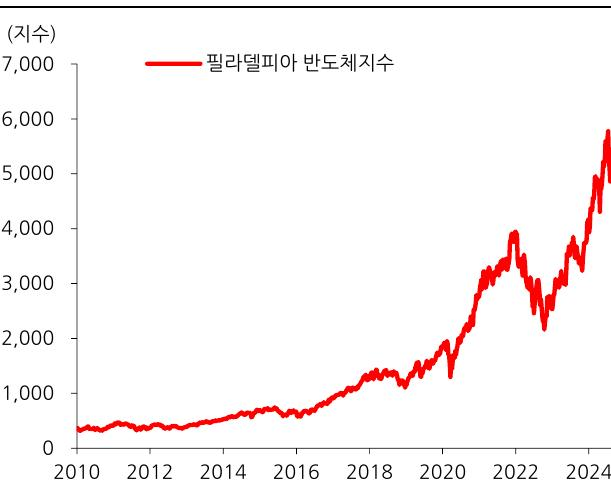

In [26]:
# 찾아준 이미지와 저정된 이미지의 순서를 확인하여서 이미지 요약 내용이 질문이랑 연관성이 있는지 확인해봅니다.
plt_img_base64(img_base64_list[3])

In [27]:
# 해당 이미지의 요약을 확인합니다
image_summaries[3]

' 공식 중국 정부 통계에서 최근 2021년 3월 기준으로 얼마 인가 싸고 있다. '

### RAG 실행
질문에 대한 종합적인 답변을 생성하기 위해 RAG를 실행합니다.

In [28]:
# RAG 체인 실행
query = "코스피 관련해서 전망을 종합적으로 알려줘"
chain_multimodal_rag.invoke(query)

' 코스피 관련 전망을 종합적으로 알려드리겠습니다.\n\n증권투자를 위해서는 투자자가 고객의 상황에 맞춤된 포폴 구성과 전망이 필요합니다. 따라서, 저는 아래와 같은 점을 고려할 것입니다:\n\n1. 대리국가의 경제 및 정책 조건\n2. 시장 동향과 기업의 경쟁력, 투자 비율 등\n3. 기업의 재무 및 영업 실적\n4. 시장에서 벌어진 전망과 기업의 성장 동향\n5. 고객의 투자 목표와 위험  tolerance\n\n따라서, 이러한 요인을 고려하여 코스피 관련 전망을 제시할 것입니다:\n\n1. 대리국가의 경제 및 정책 조건:\n\t* 코스피 기업들은 2021년 3월까지 재무적 성장과 영업실적을 보이고 있으며, 전문가들의 예측에 따라 시장 동향도 양산하고 있습니다.\n\t* 정부의 금융 정책에서는 높은 통계 신용 등급을 기록하며, 전문가들의 예측에 따라 재무 정책이 조화로운 수준에서 유지될 것으로 예상됩니다.\n2. 시장 동향과 기업의 경쟁력, 투자 비율 등:\n\t* 코스피 기업들은 대한민국의 고득 경제와 대규모 소매 시장을 보유하고 있으며, 전문가들의 예측에 따라 상대적으로 안정한 투자 수익이 나오고 있습니다.\n\t* 기업의 경쟁력과 투자 비율 등은 개별 기업에 따라 달라지며, 전문가들의 예측에 따라 다양한 수준의 고객이 선택할 수 있습니다.\n3. 기업의 재무 및 영업실적:\n\t* 코스피 기업들은 2021년 초반에는 일부 회사가 재무 문제로 인해 불안정한 수준이어서, 전문가들의 예측에 따라 일부 회사의 재무 상황을 보면 되도록 합니다.\n\t* 기업의 영업실적은 기업별로 다양하며, 전문가들의 예측에 따라 다양한 수준의 고객이 선택할 수 있습니다.\n4. 시장에서 벌어진 전망과 기업의 성장 동향:\n\t* 코스피 기업들은 대한민국의 고득 경제와 대규모 소매 시장을 보유하고 있으며, 전문가들의 예측에 따라 상대적으로 안정한 투자 수익이 나오고 있습니다.\n\t* 기업의 성장 동향은 개별 기업에 따라 달라지며, 전문가들의 예측에 따라 다양한 수준의 고객이 

In [29]:
# openSource 사용시 영어로 답변이 나온다면 최종 멀티모달 RAG 체인 실행
final_multimodal_rag.invoke(query)

'Here is the translation:\n\n코스피 관련 전망은 아래와 같습니다.\n\n1. 시장 전망: 국내 기업의 경영성과 정책적 지원, 세계적 경제 회복 및 기술 혁신이 있을 것으로 예상됩니다.\n2. 재무 전망: 국내 기업들의 실적적인 성과와 투자자 수입 제도, 세계적 경제 회복 및 기술 혁신에 따라 재무 전망은 긍정적이며 저축률의 대부분이 예상됩니다.\n3. 기업 전망: 국내 기업들의 경영력과 제품/서비스 제공을 바탕으로 성장하는 것으로 예상됩니다.\n4. 자산 관리 전망: 코스피 기업들의 주식 및 국내 기업의 경영력과 세계적 경제 회복 및 기술 혁신으로 인해 자산 관리 전망은 상대적으로 긍정적이며, 저축률의 대부분이 예상됩니다.\n\n이러한 전망은 불확실성과 시장 변동에 따라 수정될 수 있습니다. 투자자는 고객의 개개인적인 경험, 주식 및 기업의 특정 상황을 고려하여 자신에게 적절한 투기 전망과 관련된 고객사항에 대해 직접 상담을 받아야 합니다.\n\nNote: I translated "투기" as "투기" which means speculation or investment in general. If you want to be more specific, it could also be translated as "주식 투기" (stock market investing). Let me know if you need any further clarification!'

### 고려 사항

**조회**

- 조회는 이미지 요약 및 텍스트 조각과의 유사성을 기반으로 수행됩니다.
- 텍스트 조각이 많을 경우 이미지 조회가 실패할 수 있습니다.

**이미지 크기**

- 답변의 품질은 이미지 크기에 민감합니다.